# Deep dive into the population dynamics of the system
---

## Setup

In [1]:
# %pip install -e ..

In [1]:
import numpy as np
import pandas as pd
import ray
from typing import List, Text, Optional

from skopt import gp_minimize, gbrt_minimize 
from skopt import dump
from skopt.plots import plot_objective, plot_convergence
from skopt.space import Real
from skopt.utils import use_named_args

from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

from rl4fisheries import AsmEnv, Msy, ConstEsc, CautionaryRule
from rl4fisheries.envs.asm_fns import get_r_devs

## Helper functions
---
### Dynamics

In [2]:
def simulate_ep(env, agent, other_vars: Optional[List[Text]] = []):   
    simulation = {
        't': [],
        'surv_b_obs': [],
        'bare_surv_b_obs': [], 
        'mean_wt_obs': [],
        'act': [],
        'rew': [],
        'total_biomass': [],
        'newborns': [],
        'non_random_newb': [],
        **{var_name: [] for var_name in other_vars}
    }
    obs, _ = env.reset()
    for t in range(env.Tmax):
        act, _ = agent.predict(obs)
        new_obs, rew, term, trunc, info = env.step(act)
        #
        simulation['t'].append(t)
        simulation['surv_b_obs'].append(
            env.bound * (obs[0]+1)/2
        )
        simulation['bare_surv_b_obs'].append(
            obs[0]
        )
        simulation['mean_wt_obs'].append(
            (
                env.parameters["min_wt"]
                + (env.parameters["max_wt"] - env.parameters["min_wt"])
                * (obs[1]+1)/2
            )
        )
        simulation['act'].append(act[0])
        simulation['rew'].append(rew)
        simulation['total_biomass'].append(np.sum(env.state))
        simulation['newborns'].append(env.state[0])
        simulation['non_random_newb'].append(
            env.parameters["bha"] * env.ssb / (1 + env.parameters["bhb"] * env.ssb)
        )
        for var_name in other_vars:
            simulation[var_name].append(getattr(env, var_name))
        #
        obs = new_obs
    #
    return simulation

def expand_state(age_cls):
    def wrapped(row):
        return row.state[age_cls]
    return wrapped

def add_state_columns(df, env):
    df_inner = df.copy()
    for age_cls in range(len(env.state)):
        df_inner[f'age_{age_cls:02d}_b'] = df_inner.apply(expand_state(age_cls), axis=1)
    return df_inner

def prepare_for_altair(df):
    df = add_state_columns(df, env)
    melted_df = df[['t', *[f'age_{i:02d}_b' for i in range(20)]]].melt(id_vars='t')
    melted_df['population'] = melted_df['variable']
    melted_df['biomass'] = melted_df['value']
    return melted_df[['t', 'population', 'biomass']]

### Optimization


In [3]:
@ray.remote
def generate_rew(policy, env_cls, config):
    ep_rew = 0
    env = env_cls(config=config)
    obs, info = env.reset()
    for t in range(env.Tmax):
        act, info = policy.predict(obs)
        obs, rew, term, trunc, info = env.step(act)
        ep_rew += rew
    return ep_rew


def rew_batch(policy, env_cls, config, batch_size):
    tmax = env_cls().Tmax
    parallel = [generate_rew.remote(policy, env_cls, config) for _ in range(batch_size)]
    rews = ray.get(parallel)
    
    return rews

def eval_pol(policy, env_cls, config, n_batches=4, batch_size=40, pb=False):
    batch_iter = range(n_batches)
    if pb:
        from tqdm import tqdm
        batch_iter = tqdm(iter)
    #
    rews = []
    for i in batch_iter:
        rews.append(
            rew_batch(policy=policy, env_cls=env_cls, config=config, batch_size=batch_size)
        )
    return np.array(rews).flatten()

msy_space = [Real(0.001, 0.25, name='mortality')]
log_esc_space = [Real(-6, -1, name='log_escapement')]
cr_space  = [
    Real(-5, 0, name='log_radius'),
    Real(0., np.pi/4.00001, name='theta'),
    Real(0, 1, name='y2'),
]

@use_named_args(msy_space)
def msy_obj(**x):
    eval_env = AsmEnv(config=CONFIG)
    agent = Msy(env=eval_env, mortality = x['mortality'])
    rews = eval_pol(
        policy=agent, 
        env_cls=AsmEnv, config=CONFIG, 
        n_batches=4, batch_size=40
    )
    return -np.mean(rews)

@use_named_args(log_esc_space)
def esc_obj(**x):
    eval_env = AsmEnv(config=CONFIG)
    escapement = 10 ** x['log_escapement']
    agent = ConstEsc(env=eval_env, escapement = escapement)
    rews = eval_pol(
        policy=agent, 
        env_cls=AsmEnv, config=CONFIG, 
        n_batches=4, batch_size=40
    )
    return -np.mean(rews)

@use_named_args(cr_space)
def cr_obj(**x):
    theta = x["theta"]
    radius = 10 ** x["log_radius"]
    x1 = np.sin(theta) * radius
    x2 = np.cos(theta) * radius
    #
    eval_env = AsmEnv(config=CONFIG)
    eval_env.reset()
    agent = CautionaryRule(env=eval_env, x1 = x1, x2 =  x2, y2 = x["y2"])
    rews = eval_pol(
        policy=agent, 
        env_cls=AsmEnv, 
        config=CONFIG, 
        n_batches=4, batch_size=40
    )
    return -np.mean(rews)  

### Plot policy

In [4]:
def get_policy_df(policy_obj, minx=-1, maxx=1, nx=100):
    obs_list = np.linspace(minx, maxx, nx)
    return pd.DataFrame(
        {
            'obs': obs_list,
            'pop': (obs_list + 1)/2,
            'pol': [policy_obj.predict(np.float32([obs]))[0][0] for obs in obs_list]
        }
    )

## Basic dynamics: total biomass vs biomass observation

In [5]:
CONFIG1 = {"noiseless": True}
trivial_agent = Msy(env=AsmEnv(config=CONFIG1), mortality=0)
no_harvest_episode = pd.DataFrame(
    simulate_ep(env=AsmEnv(config=CONFIG1), agent=trivial_agent)
)

<Axes: xlabel='t'>

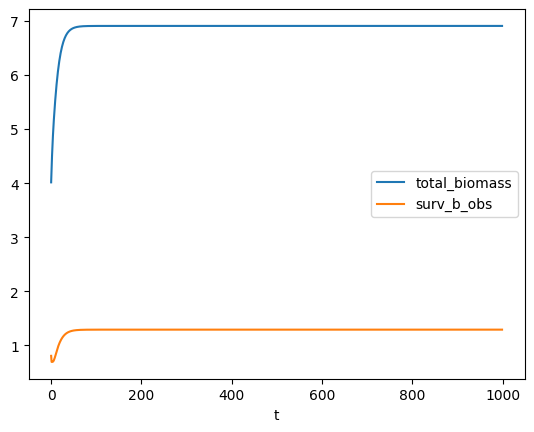

In [6]:
no_harvest_episode.plot(x='t', y=['total_biomass', 'surv_b_obs'])

In this plot we see that the biomass observation is considerably smaller than the total biomass of the system. 
This is because the values of the vector `env.parameters['survey_vul']` (the relative frequencies at which different age-classes are caught by the survey) are all smaller than one:

In [7]:
AsmEnv().parameters['survey_vul']

array([0.02918574, 0.09509395, 0.17481713, 0.2555421 , 0.33069718,
       0.3973833 , 0.45477778, 0.5031675 , 0.54337645, 0.5764369 ,
       0.6034075 , 0.6252806 , 0.64294   , 0.657148  , 0.6685485 ,
       0.6776772 , 0.68497485, 0.6908012 , 0.6954482 , 0.69915164],
      dtype=float32)

### Let's add the stochastic 'spasms' back into the mix:

<Axes: xlabel='t'>

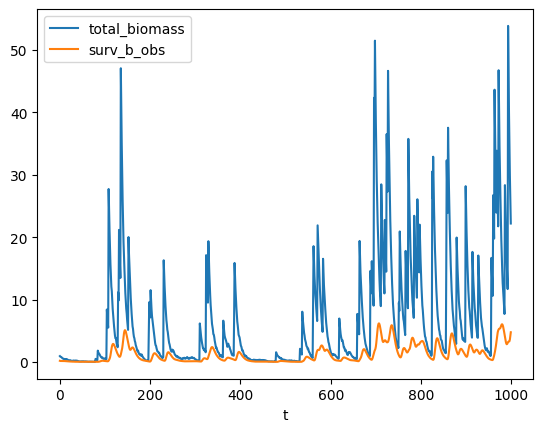

In [8]:
CONFIG2 = {"noiseless": False}
trivial_agent = Msy(env=AsmEnv(config=CONFIG2), mortality=0)
no_harvest_episode_noisy = pd.DataFrame(
    simulate_ep(env=AsmEnv(config=CONFIG2), agent=trivial_agent)
)
no_harvest_episode_noisy.plot(x='t', y=['total_biomass', 'surv_b_obs'])

Similar pattern here: although the total biomass varies up to $\sim 40$, the biomass observation never exceeds $\sim 5$.
This means that survey observations are indicators for the total biomass but not estimates for it.

Keeping in mind that the system's 'observation bound', `env.bound = 50`, this means that most of the action happens in a rather reduced portion of observation space. We can see this clearly when we look at 'bare observations' living in the space $[-1,+1]$: here the observations are all crammed in the subspace $[-1,-0.8]$.

<Axes: xlabel='t'>

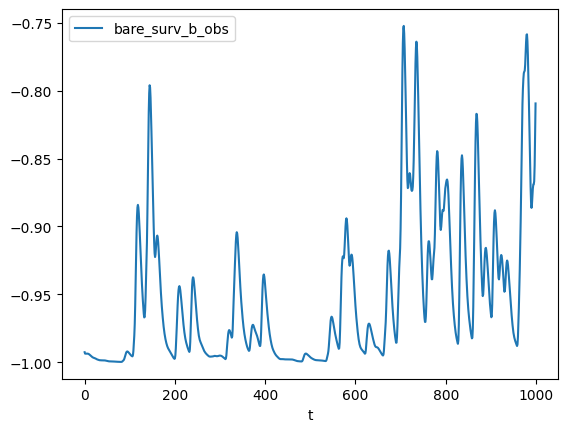

In [9]:
no_harvest_episode_noisy.plot(x='t', y=['bare_surv_b_obs'])

### Implication for policy functions:

When tuning / training policy functions 
(either 'classic' policy functions tuned using Management Strategy Evaluation, or reinforcement learning
policies tuned using RL algorithms)
this means the following:

Policies rarely use datapoints with suvey biomass observations greater than $-0.8$ to train. 
That part of observation space, $[-0.8, +1]$ is simply one which is rarely visited at all.
This way, policy values in this region of observation space have little interpretability:
the policy function is tuned using time-series of episodes that mostly 'live' in $[-1, -0.8]$.

Correspondingly, we get policy functions who's interesting portion is all concentrated on this
slice of observation space.

### Examples

For example, consider the optimal escapement strategy which is seemingly extreme, using an escapement biomass of $\approx 0.01$. (Compare this tiny value to the typical biomass scale at which the unfished system fluctuates - in the order of 10-50 biomass units!)

<Axes: title={'center': 'Optimal escapement policy'}, xlabel='pop'>

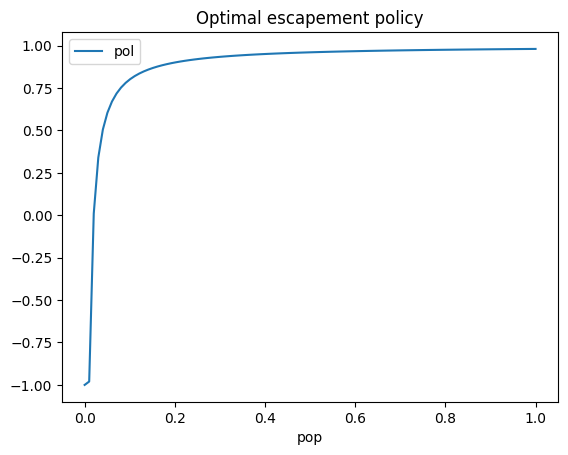

In [10]:
get_policy_df(ConstEsc(env=AsmEnv(config=CONFIG2), escapement=0.01)).plot(x='pop', y='pol', title='Optimal escapement policy')

Initially I was taken aback looking at this optimal policy: it seems like an extremist 'always fish as much as possible' policy - a boundary solution. When plotting the average episode reward vs log-escapement, however, we see that this is not a boundary solution:

![title](escapement_rewards.png)

Here, the *negative* reward is plotted as a function of log-escapement (sorry for the weird y-axis name!).

This was contrasted by the optimal constant-effort strategy, with an MSY mortality of 5%. I was definitely scratching my head at that contrast.

## Lowered bound

<Axes: xlabel='t'>

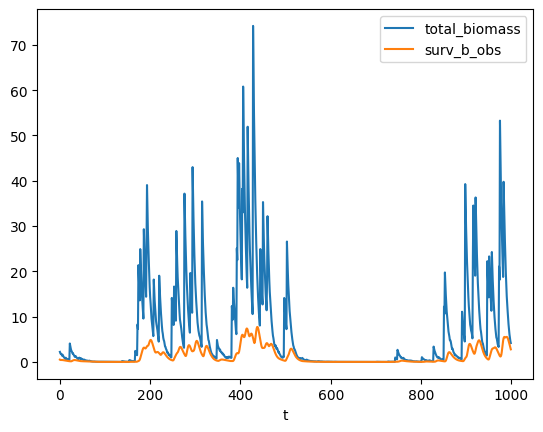

In [14]:
CONFIG3 = {"noiseless": False, "bound": 10}
trivial_agent = Msy(env=AsmEnv(config=CONFIG2), mortality=0)
no_harvest_episode_noisy = pd.DataFrame(
    simulate_ep(env=AsmEnv(config=CONFIG2), agent=trivial_agent)
)
no_harvest_episode_noisy.plot(x='t', y=['total_biomass', 'surv_b_obs'])

<Axes: xlabel='t'>

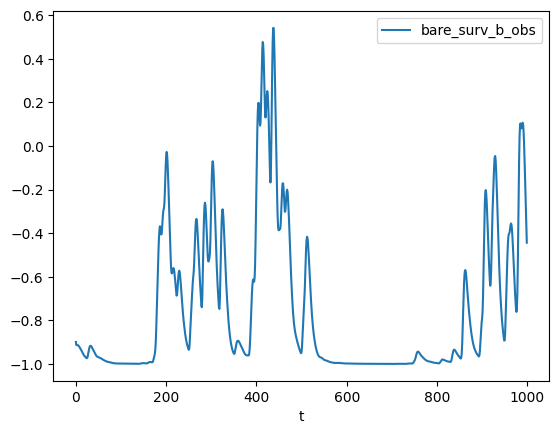

In [15]:
no_harvest_episode_noisy.plot(x='t', y=['bare_surv_b_obs'])

Pretty much same dynamics, but now our bound used for observation space matches the scale at which observations happen. Let's optimize to find the optimal escapement---the escapement function plot should look less crammed.

In [17]:
%%time
CONFIG=CONFIG3
esc_gp = gp_minimize(esc_obj, log_esc_space, n_calls = 50, verbose=True, n_jobs=-1)
esc_gp.fun, esc_gp.x

Iteration No: 1 started. Evaluating function at random point.


2024-04-10 22:25:13,894	INFO worker.py:1752 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5.0892
Function value obtained: -1.9766
Current minimum: -1.9766
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.9183
Function value obtained: -2.4964
Current minimum: -2.4964
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.8939
Function value obtained: -87.6669
Current minimum: -87.6669
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.8825
Function value obtained: -12.3996
Current minimum: -87.6669
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.7935
Function value obtained: -4.1797
Current minimum: -87.6669
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ende

(-89.11450923243565, [-1.2382929119922421])

<Axes: title={'center': 'Optimal escapement policy'}, xlabel='pop'>

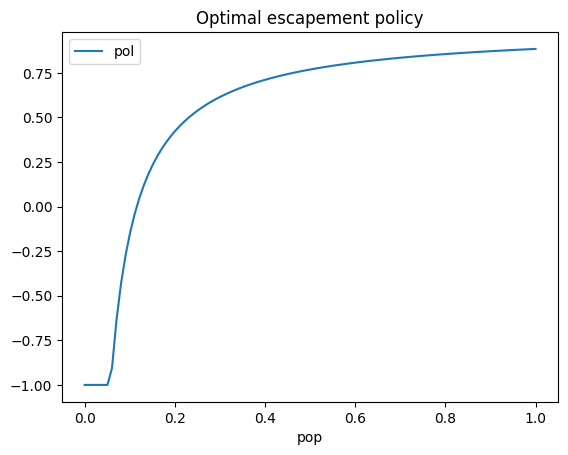

In [20]:
esc = 10 ** esc_gp.x[0]

get_policy_df(ConstEsc(env=AsmEnv(config=CONFIG3), escapement=esc)).plot(x='pop', y='pol', title='Optimal escapement policy')

In [23]:
env = AsmEnv(config=CONFIG3)
env.reset()
env.parameters["wt"]

array([0.00867406, 0.05012764, 0.12382168, 0.2176034 , 0.3191206 ,
       0.4192168 , 0.5122158 , 0.5952108 , 0.667202  , 0.7283712 ,
       0.7795541 , 0.8218887 , 0.856597  , 0.8848603 , 0.9077545 ,
       0.92622364, 0.9410753 , 0.952988  , 0.9625244 , 0.9701466 ],
      dtype=float32)

In [24]:
env.parameters["max_wt"]

0.9701466

In [31]:
pop1 = np.array([1] + [0] * 19)
n1 = sum(pop1 / env.parameters["wt"])
mwt1 = 1 / n1

pop2 = np.array([0] * 19 + [1])
n2 = sum(pop2 / env.parameters["wt"])
mwt2 = 1 / n2

pop3 = np.array([0] * 4 + [1] + [0] * 15)
n3 = sum(pop3 / env.parameters["wt"])
mwt3 = 1 / n3

mwt1, mwt2, mwt3,

(0.008674059994518757, 0.9701465964317322, 0.3191205859184265)